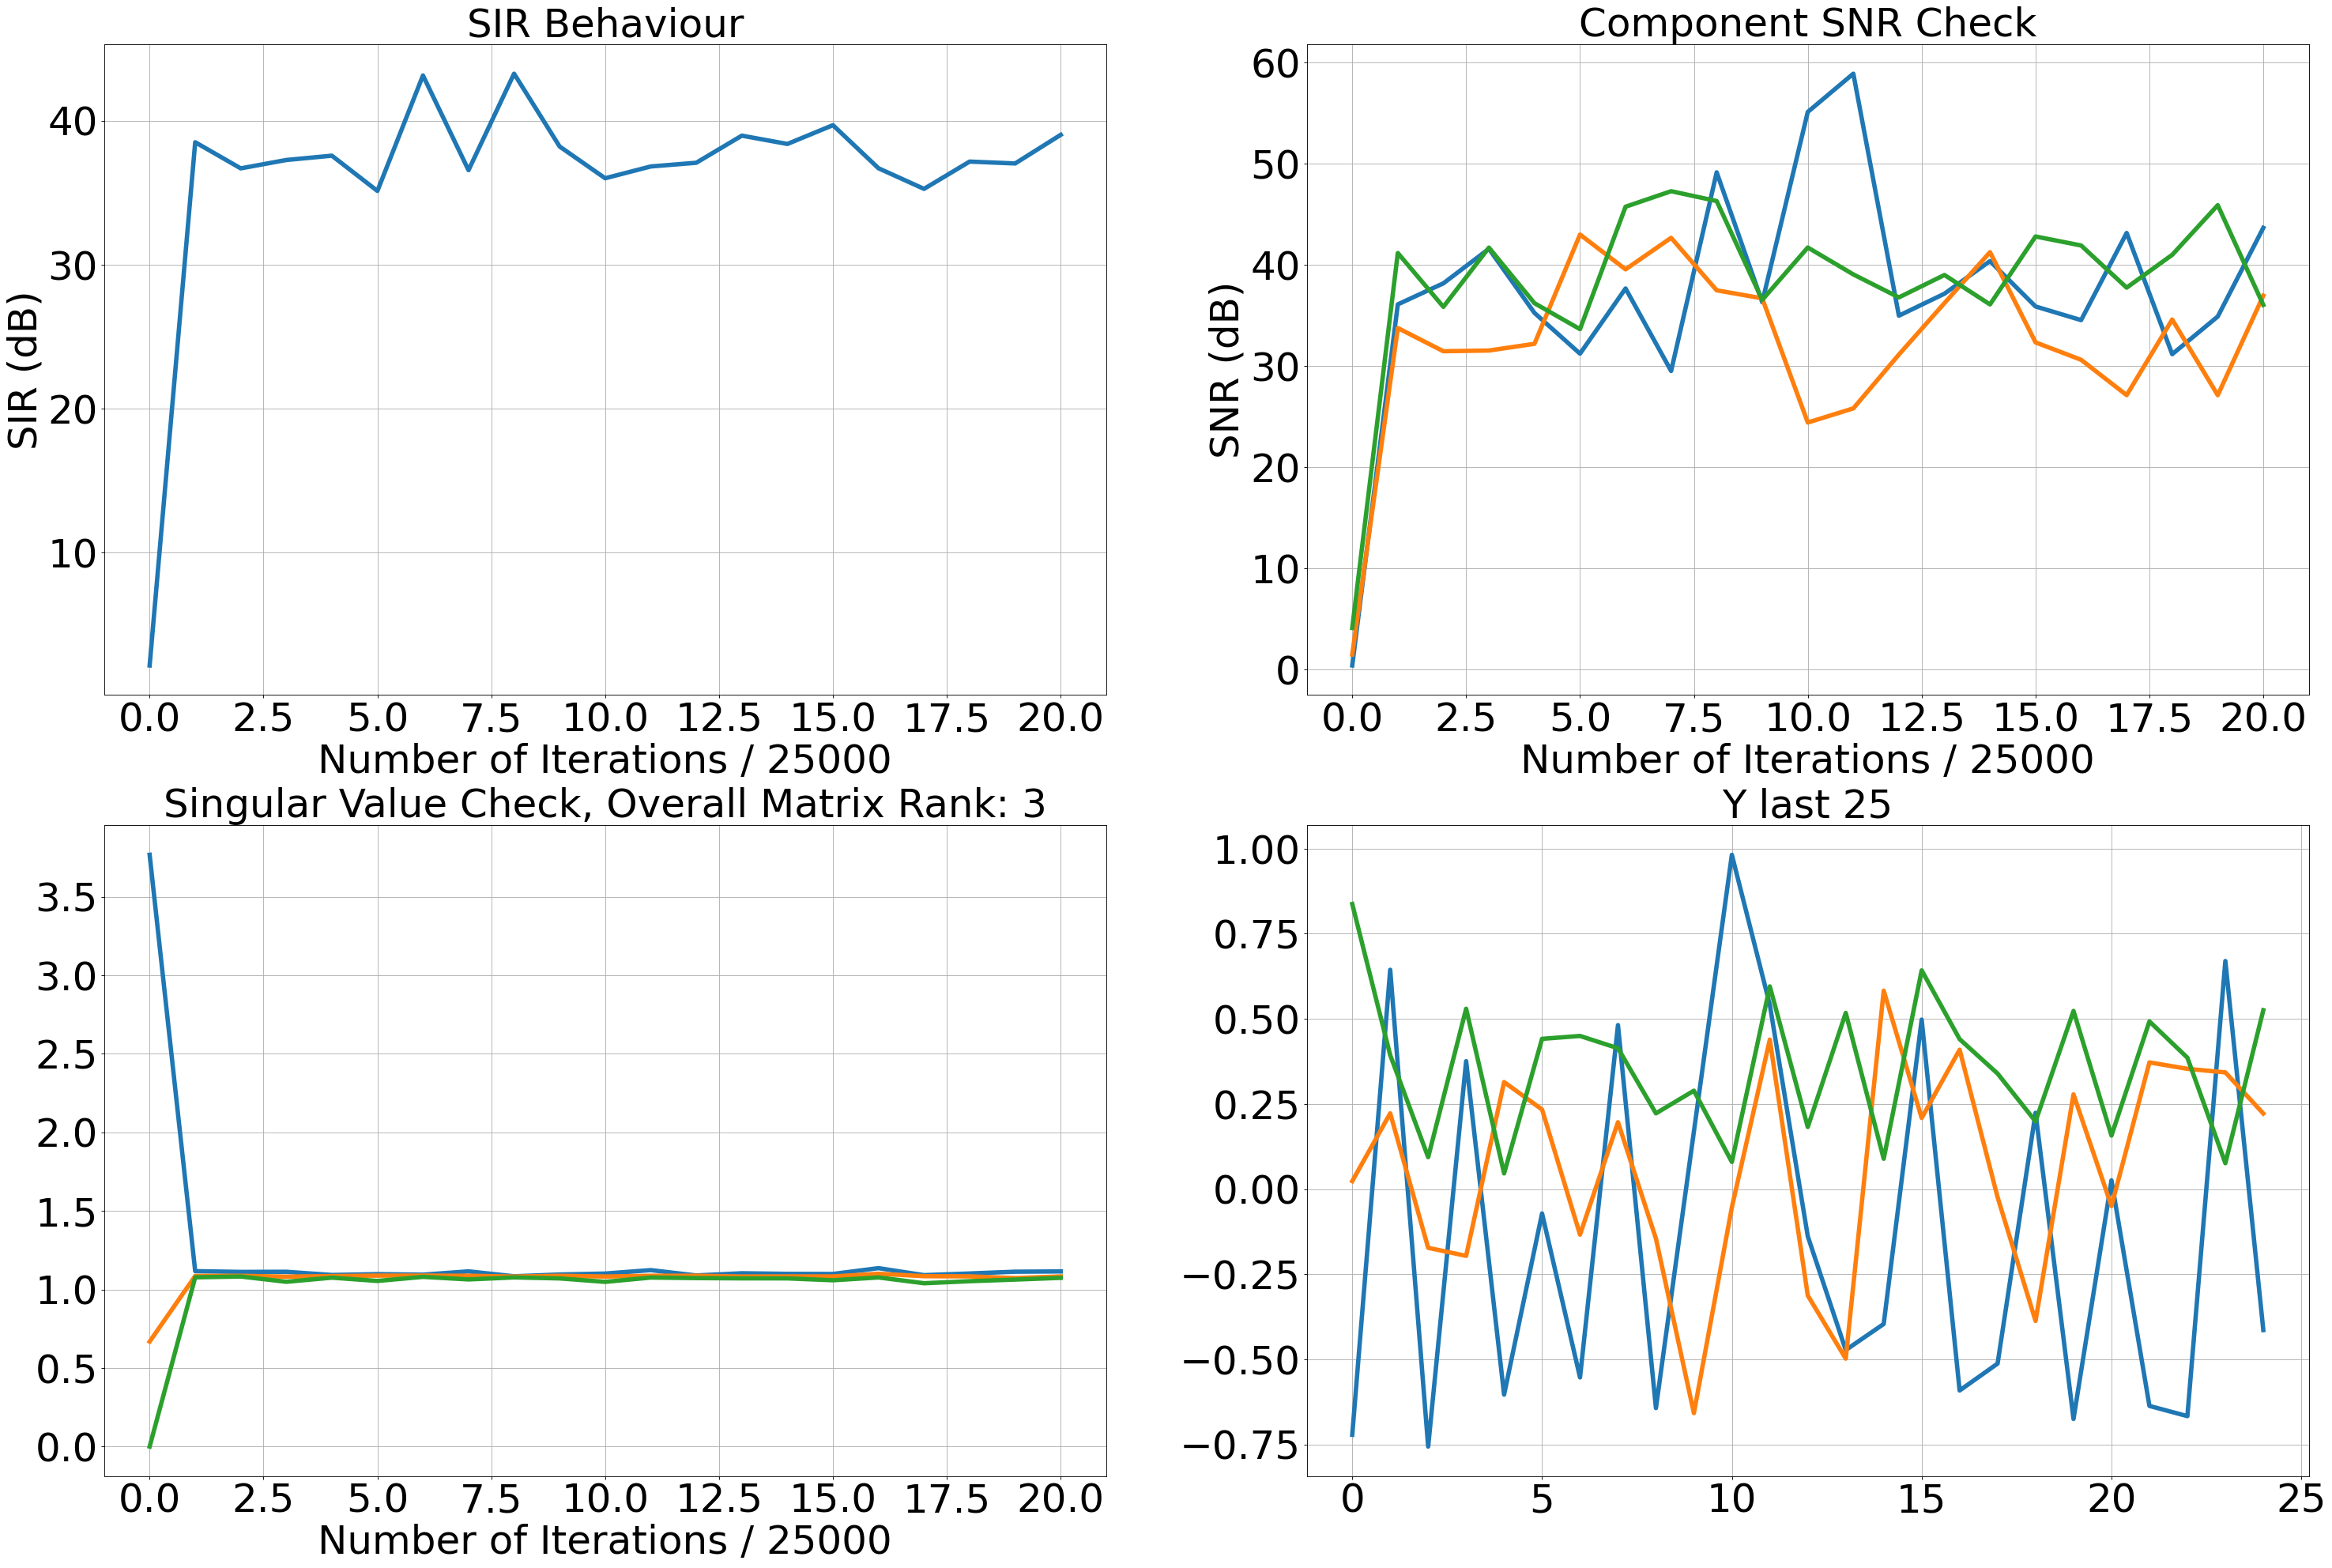

100%|██████████| 500000/500000 [05:38<00:00, 1476.63it/s]


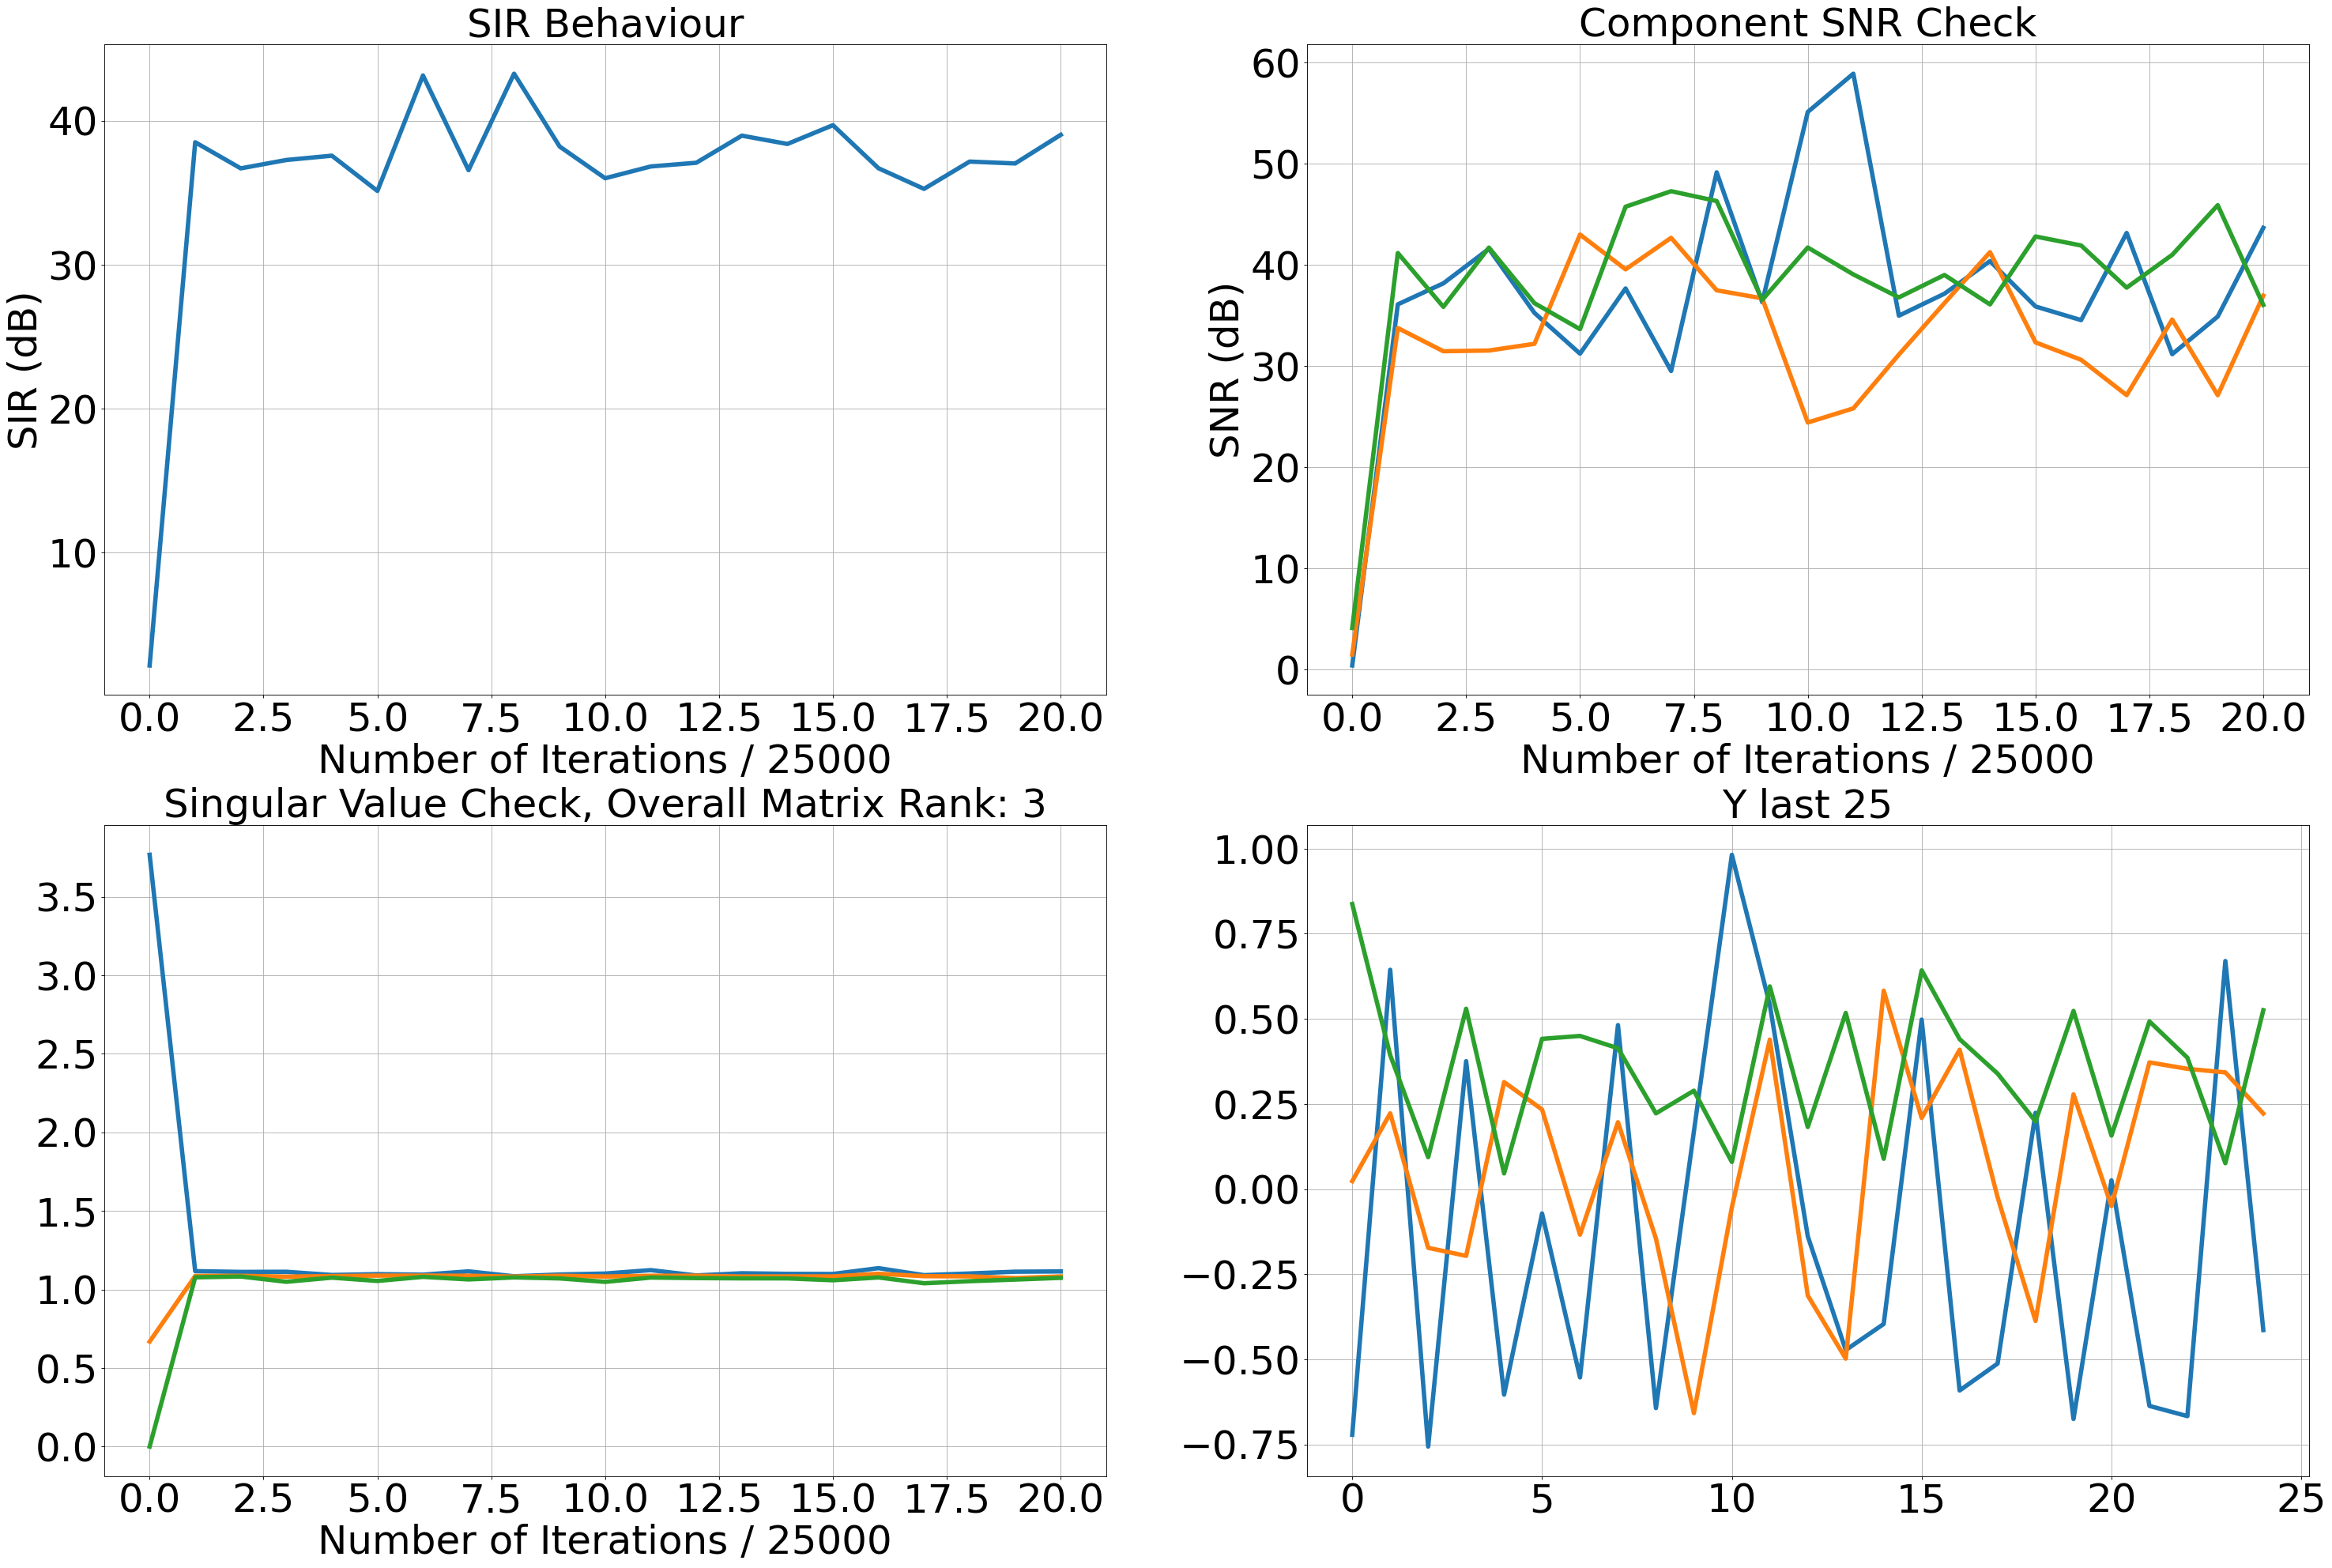

In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from numba import njit
import pypoman
########## IMPORT UTILITY SCRIPTS ##############
import sys
sys.path.insert(0, '../../src')
from general_utils import *
from dsp_utils import *
from bss_utils import *
from numba_utils import *
######## IMPORT THE REQUIRED ALGORITHMS ########
from LDMIBSS import LDMIBSS
from CorInfoMaxBSS import OnlineCorInfoMaxCanonical
from PMF import PMF
from polytope_utils import generate_practical_polytope

import warnings
warnings.filterwarnings("ignore")

if not os.path.exists("../Results"):
    os.mkdir("../Results")

pickle_name_for_results = "simulation_results_general_polytope_3dimV2.pkl"

N = 500000 ## Number of data points
NumberofSources = 3 ## Number of source vectors
NumberofMixtures = 6 ## Number of mixture vectors

s_dim = NumberofSources
x_dim = NumberofMixtures

SNRlevel = 30

NumAverages = 100 ## Number of realizations to average for each algorithm
seed_list = np.array([7586931 * i for i in range(NumAverages)]) ## Seeds for reproducibility

dim = NumberofSources

signed_dims = np.array([0, 1])
nn_dims = np.array([2])
sparse_dims_list = [np.array([0, 1]), np.array([1, 2])]
(Apoly, bpoly), Verts_poly = generate_practical_polytope(dim, signed_dims, nn_dims, sparse_dims_list)
# print(Apoly.shape, bpoly.shape)
Apoly, bpoly = pypoman.compute_polytope_halfspaces(Verts_poly.T)
# print(Apoly.shape, bpoly.shape)
########################################################################################
########################################################################################
###                                                                                  ###
###                        SIMULATION                                                ###
###                                                                                  ###
########################################################################################
########################################################################################

RESULTS_DF = pd.DataFrame( columns = ['trial', 'seed', 'Model', 'SINR', 'SINRlist', 'SNR', 'S', 'A', 'X', 'Wf', 'SNRinp', 'execution_time'])

####### YOU MIGHT WANT TO CHANGE THE DEBUG ITERATION POINT FOR MEMORY PURPOSES #######
debug_iteration_point = 25000 # SINR measurement per 10000 iteration

for iter1 in range(NumAverages): ## Loop over number of averages
    seed_ = seed_list[iter1] ## Set the seed for reproducibility
    np.random.seed(seed_)
    trial = iter1

    S = generate_uniform_points_in_polytope(Verts_poly, N)

    A = np.random.randn(NumberofMixtures, NumberofSources)
    X = np.dot(A, S)
    Xnoisy, NoisePart = addWGN(X, SNRlevel, return_noise = True) ## Add White Gaussian Noise with 30 dB SNR
    SNRinplevel = 10 * np.log10(np.sum(np.mean((Xnoisy - NoisePart) ** 2, axis = 1)) / np.sum(np.mean(NoisePart ** 2, axis = 1)))

    #######################################################
    #        Online CorInfoMax Setup 1                    #
    #######################################################
    try: # Try Except for SVD did not converge error (or for any other error)
        lambday = 1 - 1e-1 / 10
        lambdae = 1 - 1e-1 / 10
        s_dim = S.shape[0]
        x_dim = X.shape[0]

        # Inverse output covariance
        By = 5 * np.eye(s_dim)
        # Inverse error covariance
        Be = 1000 * np.eye(s_dim)

        modelCorInfoMax = OnlineCorInfoMaxCanonical(
                                                    s_dim=s_dim,
                                                    x_dim=x_dim,
                                                    muW=50 * 1e-3,
                                                    lambday=lambday,
                                                    lambdae=lambdae,
                                                    By=By,
                                                    Be=Be,
                                                    neural_OUTPUT_COMP_TOL=1e-6,
                                                    set_ground_truth=True,
                                                    S=S,
                                                    A=A,
                                                )
        with Timer() as t:
            modelCorInfoMax.fit_batch(
                                        X=X,
                                        Apoly = Apoly,
                                        bpoly = bpoly,
                                        n_epochs=1,
                                        neural_dynamic_iterations=500,
                                        plot_in_jupyter=True,
                                        neural_lr_start=0.25, 
                                        neural_lr_stop=1e-4,
                                        debug_iteration_point=debug_iteration_point,
                                        shuffle=False,
                                    )
        ######### Evaluate the Performance of CorInfoMax Framework ###########################
        SINRlistCorInfoMax = modelCorInfoMax.SIR_list
        WfCorInfoMax = modelCorInfoMax.compute_overall_mapping(return_mapping = True)
        YCorInfoMax = WfCorInfoMax @ Xnoisy
        SINRCorInfoMax, SNRCorInfoMax, _, _, _ = evaluate_bss(WfCorInfoMax, YCorInfoMax, A, S, mean_normalize_estimations = False)
    except:
        print("s")
    break

In [2]:
WfCorInfoMax = modelCorInfoMax.compute_overall_mapping(return_mapping = True)
YCorInfoMax = WfCorInfoMax @ X
SINRCorInfoMax, SNRCorInfoMax, _, _, _ = evaluate_bss(WfCorInfoMax, YCorInfoMax, A, S, mean_normalize_estimations = False)
SINRCorInfoMax

39.00765326484248